In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp

In [2]:
import sys
sys.path.append("../..")

from adversarial_ntks import attacks

In [3]:
np.random.seed(42)

## Generating data

We sample two Gaussians in $D$ dimensions with standard deviations $\sigma_0$ and $\sigma_1$.

The radii of the two Gaussians are thus $R_i = \sigma_i \cdot \sqrt{D}$.

In [4]:
def normalize(xs: np.ndarray, norm):
    norm_xs = xs / np.linalg.norm(xs, axis=-1, ord=norm).reshape(-1, 1)
    return norm_xs

def gen_data(d, r0, r1, num_samples):
    sigma0, sigma1 = r0 / np.sqrt(d), r1 / np.sqrt(d)
    
    xs0 = np.random.normal(size=(num_samples, d), scale=sigma0)
    xs1 = np.random.normal(size=(num_samples, d), scale=sigma1)
    
    return xs0, xs1

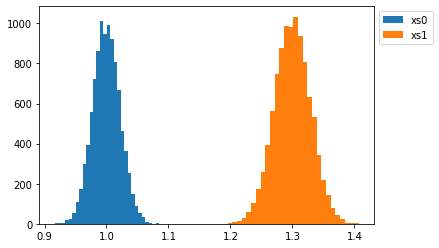

In [5]:
# The standard experimental parameters for this notebook
_D = 1000
_R0, _R1 = 1.0, 1.3
_SIGMA0, _SIGMA1 = _R0 / np.sqrt(_D), _R1 / np.sqrt(_D)
_COV0, _COV1 = _SIGMA0 ** 2 * np.eye(_D), _SIGMA1 ** 2 * np.eye(_D)
_NUM_SAMPLES = 10 ** 4
_XS0, _XS1 = gen_data(d=_D, r0=_R0, r1=_R1, num_samples=_NUM_SAMPLES)
# DO NOT MUTATE after this point

plt.hist(np.linalg.norm(_XS0, ord=2, axis=-1), bins=30, label="xs0");
plt.hist(np.linalg.norm(_XS1, ord=2, axis=-1), bins=30, label="xs1");
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

## Learning the mean
We use the sample mean $\hat{\mu} = \frac{1}{n} \sum_{i = 1}^n x_i$.

In [6]:
def est_mean(xs):
    return xs.mean(axis=0)

xs0, xs1 = gen_data(
    d=1000, r0=1.0, r1=1.3, num_samples=10 ** 4
)
muh0, muh1 = est_mean(xs0), est_mean(xs1)
np.linalg.norm(muh0), np.linalg.norm(muh1)

(0.010063776935204275, 0.013203258364833798)

In 1000 dimensions with $R_0 = 1$ and $R_1 = 1.3$ and 10k samples,
our estimated means are off by ~1e-2, which is accurate enough for robust classification.

## Learning covariance (assuming zero mean)
We use the empirical covariance.
$$\hat{\Sigma} = \frac{1}{n} \sum_{i=1}^n x_i x_i^\top.$$

In [7]:
def est_cov(xs):
    num_samples = xs.shape[0]
    return (xs.T @ xs) / num_samples

covh0, covh1 = est_cov(_XS0), est_cov(_XS1)
covh0.shape, covh1.shape

((1000, 1000), (1000, 1000))

#### Learned covariances: singular values

They singular values of $\hat{\Sigma}_i$ are concentrated around $\sigma_i^2$,
and take a Marchenko–Pastur distribution.

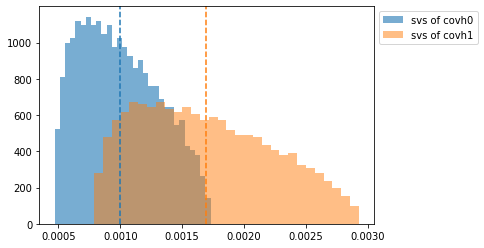

In [8]:
def hist_svs(hmat, **kwargs):
    """hmat a hermitian matrix"""
    svs = np.linalg.svd(hmat, compute_uv=False, hermitian=True)
    plt.hist(svs, **kwargs)
    
hist_svs(covh0, label="svs of covh0", bins=30, density=True, alpha=0.6)
hist_svs(covh1, label="svs of covh1", bins=30, density=True, alpha=0.5)

plt.axvline(_SIGMA0 ** 2, color="C0", ls="--");
plt.axvline(_SIGMA1 ** 2, color="C1", ls="--");

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

#### Learned covariances: singular values Mk. 2
This time we first transform coordinates such that $\hat{\Sigma}_0$ is the identity matrix.
We then plot the singular values of $\hat{\Sigma}_1$.

In the infinite sample regime, the singular values of $\hat{\Sigma}_1$ with respect to $\hat{\Sigma}_0$
should be concentrated around $(\sigma_1 / \sigma_0)^2$.

We also to the reverse.

In [9]:
def normalize_wrt(target: np.ndarray, base: np.ndarray):
    """
    target and base are square symmetric matrices.
    This function transforms coordinates so that base is the identity,
    then returns target in the transformed coordinates.
    """
    isqrt_base = np.linalg.inv(scipy.linalg.sqrtm(base))
    return isqrt_base @ target @ isqrt_base

# Check normalize_wrt returns the identity when target=base
np.allclose(
    normalize_wrt(target=covh0, base=covh0),
    np.eye(covh1.shape[0])
)

True

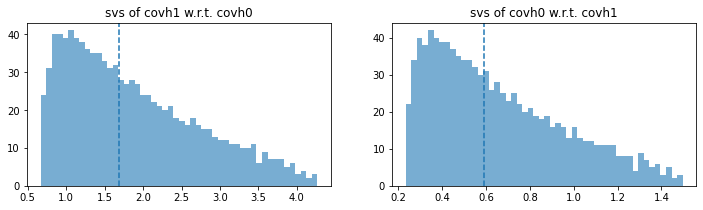

In [10]:
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
hist_svs(normalize_wrt(target=covh1, base=covh0), bins=50, alpha=0.6)
plt.axvline((_SIGMA1 / _SIGMA0) ** 2, color="C0", ls="--");
plt.title("svs of covh1 w.r.t. covh0");

plt.subplot(1, 2, 2)
hist_svs(normalize_wrt(target=covh0, base=covh1), bins=50, alpha=0.6)
plt.axvline((_SIGMA0 / _SIGMA1) ** 2, color="C0", ls="--");
plt.title("svs of covh0 w.r.t. covh1");

# Performance of likelihood-ratio test
This test assumes each class conditional distribution is
$\mathcal{N}(\hat{\mu}, \hat{\Sigma})$.

In [35]:
@jax.jit
def gaussian_log_likelihood(
    xs: np.ndarray,
    mu: np.ndarray,
    cov: np.ndarray,
):
    """
    xs of shape (num_samples, dim)
    cov of shape (dim, dim)
    return shape: (num_samples, )
    """
    icov = jnp.linalg.inv(cov)
    return (
        - 0.5 * jnp.linalg.slogdet(cov)[1]
        - 0.5 * jnp.einsum("ij,jk,ki->i", (xs - mu), icov, (xs - mu).T, optimize=True)
    )

@jax.jit
def gaussian_ll_diffs(xs, mu0, cov0, mu1, cov1):
    ll0 = gaussian_log_likelihood(xs, mu=mu0, cov=cov0)
    ll1 = gaussian_log_likelihood(xs, mu=mu1, cov=cov1)
    ll_diffs = ll1 - ll0
    return ll_diffs

def gaussian_lr_predict(xs, mu0, cov0, mu1, cov1):
    """
    Likelihood ratio test classification
    Returns preds, diffs
    """
    diffs = gaussian_ll_diffs(xs, mu0, cov0, mu1, cov1)
    return (diffs >= 0).astype(int)

### Behavior of LRT vs. radius

In [36]:
def cls1_frac_by_rad(
    classifier,
    rads: np.ndarray,
    dim: int,
    num_samples_per_rad=256,
):    
    cls1_fracs = np.zeros_like(rads)
    for idx, r in enumerate(tqdm(rads, leave=False)):
        xs = r * normalize(
            xs=np.random.normal(size=(num_samples_per_rad, dim)),
            norm=2
        )

        preds = classifier(xs)
        cls1_fracs[idx] = (preds == 1).mean()
        
    return cls1_fracs

First the case where we know the true mean and covariance.

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 42.2 s, total: 2min 11s
Wall time: 17.4 s


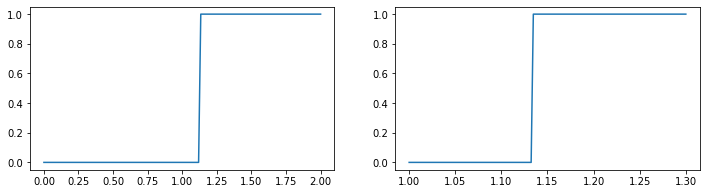

In [37]:
%%time
covh0, covh1 = est_cov(_XS0), est_cov(_XS1)
muh0

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(
    rads=rads, dim=_D,
    classifier=lambda xs: gaussian_lr_predict(xs, mu0=0, cov0=_COV0, mu1=0, cov1=_COV1)
)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=1.0, stop=1.3, num=128)
cls1_fracs = cls1_frac_by_rad(
    rads=rads, dim=_D,
    classifier=lambda xs: gaussian_lr_predict(xs, mu0=0, cov0=_COV0, mu1=0, cov1=_COV1)
)
plt.plot(rads, cls1_fracs);

We note that the optimal decision boundary for natural accuracy
is slightly smaller than the optimal decision boundary for L2 robust accuracy.

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 42.6 s, total: 2min 12s
Wall time: 16.8 s


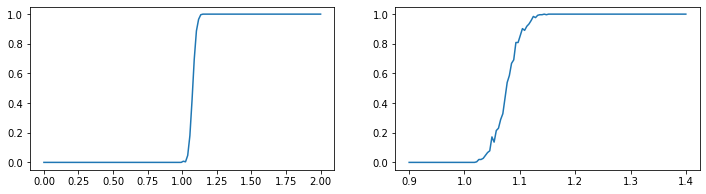

In [40]:
%%time
plt.figure(figsize=(12, 3))

muh0, muh1 = est_mean(_XS0), est_mean(_XS1)
covh0, covh1 = est_cov(_XS0), est_cov(_XS1)

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(
    rads=rads, dim=_D,
    classifier=lambda xs: gaussian_lr_predict(xs, mu0=muh0, cov0=covh0, mu1=muh0, cov1=covh1)
)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.9, stop=1.4, num=128)
cls1_fracs = cls1_frac_by_rad(
    rads=rads, dim=_D,
    classifier=lambda xs: gaussian_lr_predict(xs, mu0=muh0, cov0=covh0, mu1=muh0, cov1=covh1)
)
plt.plot(rads, cls1_fracs);

In [10]:
X1_test, X2_test= np.random.normal(size=(1000, D), scale=R1)
X2_test = np.random.normal(size=(1000, D), scale=R2)

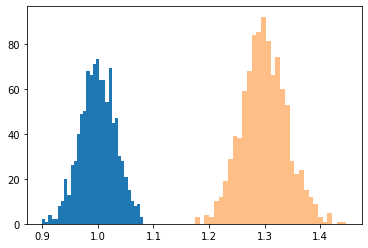

In [11]:
plt.hist(np.linalg.norm(X1_test, axis=1) / np.sqrt(D), bins=32);
plt.hist(np.linalg.norm(X2_test, axis=1) / np.sqrt(D), bins=32, alpha=0.5);

## Natural accuracy

preds1 acc: 1.0
preds2 acc: 1.0


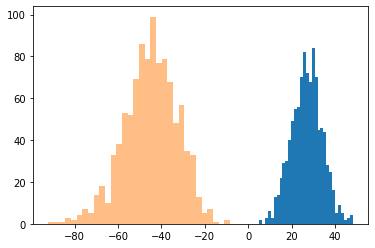

In [12]:
preds1, diffs1 = gaussian_lr_classify(X1_test, cov1=covh1, cov2=covh2, mu1=muh1, mu2=muh2)
preds2, diffs2 = gaussian_lr_classify(X2_test, cov1=covh1, cov2=covh2, mu1=muh1, mu2=muh2)

print(f"preds1 acc: {preds1.mean()}")
print(f"preds2 acc: {1 - preds2.mean()}")

plt.hist(diffs1, bins=32);
plt.hist(diffs2, bins=32, alpha=0.5);

##### Known mean

preds1 acc: 1.0
preds2 acc: 1.0


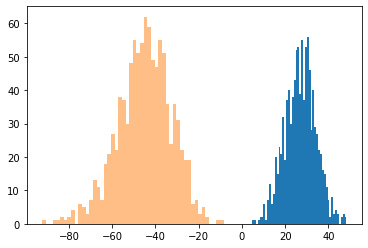

In [13]:
preds1, diffs1 = gaussian_lr_classify(X1_test, cov1=covh1, cov2=covh2)
preds2, diffs2 = gaussian_lr_classify(X2_test, cov1=covh1, cov2=covh2)

print(f"preds1 acc: {preds1.mean()}")
print(f"preds2 acc: {1 - preds2.mean()}")

plt.hist(diffs1, bins=50);
plt.hist(diffs2, bins=50, alpha=0.5);

### Adversarial accuracy

preds1 acc: 0.7360000014305115
preds2 acc: 0.9710000157356262


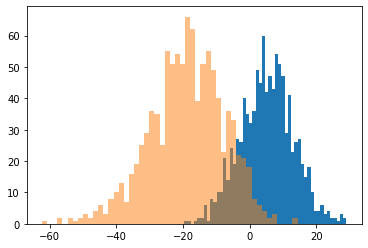

In [14]:
X1_test_norm = X1_test / np.linalg.norm(X1_test, axis=1).reshape(-1, 1)
X2_test_norm = X2_test / np.linalg.norm(X2_test, axis=1).reshape(-1, 1)
eps = 0.1 * np.sqrt(D)

preds1, diffs1 = gaussian_lr_classify(X1_test + eps * X1_test_norm, cov1=covh1, cov2=covh2, mu1=muh1, mu2=muh2)
preds2, diffs2 = gaussian_lr_classify(X2_test - eps * X2_test_norm, cov1=covh1, cov2=covh2, mu1=muh1, mu2=muh2)

print(f"preds1 acc: {preds1.mean()}")
print(f"preds2 acc: {1 - preds2.mean()}")

plt.hist(diffs1, bins=50);
plt.hist(diffs2, bins=50, alpha=0.5);

##### Known mean

preds1 acc: 0.7350000143051147
preds2 acc: 0.9700000286102295


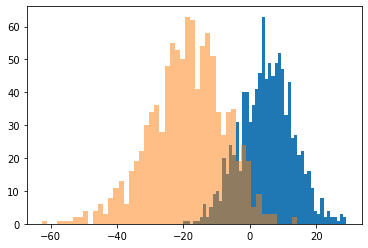

In [15]:
preds1, diffs1 = gaussian_lr_classify(X1_test + eps * X1_test_norm, cov1=covh1, cov2=covh2)
preds2, diffs2 = gaussian_lr_classify(X2_test - eps * X2_test_norm, cov1=covh1, cov2=covh2)

print(f"preds1 acc: {preds1.mean()}")
print(f"preds2 acc: {1 - preds2.mean()}")

plt.hist(diffs1, bins=50);
plt.hist(diffs2, bins=50, alpha=0.5);

##### Perfect classifier

preds1 acc: 0.8489999771118164
preds2 acc: 0.9490000009536743


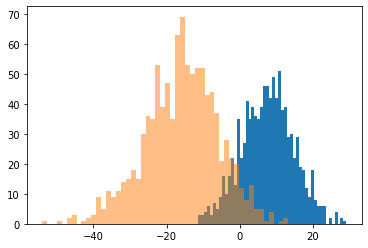

In [17]:
preds1, diffs1 = gaussian_lr_classify(X1_test + eps * X1_test_norm, cov1=(R1 ** 2) * np.eye(D), cov2=(R2 ** 2) * np.eye(D))
preds2, diffs2 = gaussian_lr_classify(X2_test - eps * X2_test_norm, cov1=(R1 ** 2) * np.eye(D), cov2=(R2 ** 2) * np.eye(D))

print(f"preds1 acc: {preds1.mean()}")
print(f"preds2 acc: {1 - preds2.mean()}")

plt.hist(diffs1, bins=50);
plt.hist(diffs2, bins=50, alpha=0.5);

##### Perfect classifier

In [ ]:
preds1, diffs1 = gaussian_lr_classify(X1_test + eps * X1_test_norm, cov1=(R1 ** 2) * np.eye(D), cov2=(R2 ** 2) * np.eye(D))
preds2, diffs2 = gaussian_lr_classify(X2_test - eps * X2_test_norm, cov1=(R1 ** 2) * np.eye(D), cov2=(R2 ** 2) * np.eye(D))

print(f"preds1 acc: {preds1.mean()}")
print(f"preds2 acc: {1 - preds2.mean()}")

plt.hist(diffs1, bins=50);
plt.hist(diffs2, bins=50, alpha=0.5);

##### PGD

In [19]:
def tot_gaussian_ll_diff(X, cov1, cov2, mu1, mu2):
    return gaussian_ll_diffs(X, cov1, cov2, mu1, mu2).sum()

grad_tot_gaussian_ll_diff = jax.jit(jax.grad(tot_gaussian_ll_diff))

In [23]:
%%time

eps = 0.1 * np.sqrt(D)

X1_test_adv = attacks.pgd(
    X=X1_test,
    Y=np.ones(X1_test.shape[0]),
    grad_func=lambda X: grad_tot_gaussian_ll_diff(X, covh1, covh2, muh1, muh2),
    eps=eps,
    eps_norm=2,
    num_steps=20,
    step_size=0.1 * np.sqrt(D) / 10,
    step_norm=2,
    pixel_clip=False
)

X2_test_adv = attacks.pgd(
    X=X2_test,
    Y=np.zeros(X1_test.shape[0]),
    grad_func=lambda X: grad_tot_gaussian_ll_diff(X, covh1, covh2, muh1, muh2),
    eps=eps,
    eps_norm=2,
    num_steps=20,
    step_size=0.1 * np.sqrt(D) / 10,
    step_norm=2,
    pixel_clip=False
)

CPU times: user 7.08 s, sys: 4.86 s, total: 11.9 s
Wall time: 1.51 s


preds1 adv acc: 0.6850000023841858
preds2 adv acc: 0.953000009059906


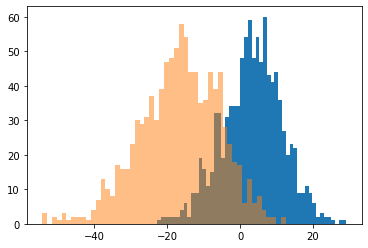

In [24]:
preds1, diffs1 = gaussian_lr_classify(X1_test_adv, cov1=covh1, cov2=covh2, mu1=muh1, mu2=muh2)
preds2, diffs2 = gaussian_lr_classify(X2_test_adv, cov1=covh1, cov2=covh2, mu1=muh1, mu2=muh2)

print(f"preds1 adv acc: {preds1.mean()}")
print(f"preds2 adv acc: {1 - preds2.mean()}")

plt.hist(diffs1, bins=50);
plt.hist(diffs2, bins=50, alpha=0.5);